In [1]:
TCOLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral(Omentum)":"orange",
    "Brain-Caudate(basalganglia)":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed(Suprapubic)":"blue",
    "Skin-SunExposed(Lowerleg)":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

In [2]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns

# Get all analyzed STRs
all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","str.start","end"])
all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)

# Load other "distances"
ANNOTDIR = "/storage/mgymrek/gtex/annotations"
acc = pd.read_csv(os.path.join(ANNOTDIR, "acceptorsites_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.acc"])
donor = pd.read_csv(os.path.join(ANNOTDIR, "donorsites_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.donor"])
dnaseI = pd.read_csv(os.path.join(ANNOTDIR, "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])
weakenh = pd.read_csv(os.path.join(ANNOTDIR, "weak_enhancer_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.wenh"])
strongenh = pd.read_csv(os.path.join(ANNOTDIR, "strong_enhancer_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.senh"])

# Get causal/best per gene for each tissue
DATADIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
OUTPATH = "pdfs/"
TISSUES = [
    'Brain-Caudate(basalganglia)',
    'Brain-Cerebellum',
         'Muscle-Skeletal',
    'Cells-Transformedfibroblasts',
     'Esophagus-Mucosa',
     'Skin-NotSunExposed(Suprapubic)',
     'Skin-SunExposed(Lowerleg)',
     'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Adipose-Subcutaneous',
    'Adipose-Visceral(Omentum)',
     'Lung',
     'Thyroid',
     'Nerve-Tibial',
     'Heart-LeftVentricle',
     'WholeBlood',
]
data = {}
for t in TISSUES:
    x = pd.read_csv(os.path.join(DATADIR, t, "Master.table"), sep="\t")
    data[t] = x 

# Get motifs
hipmotifs = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed", sep="\t", names=["chrom","str.start","str.end","period","motif"])
all_strs = pd.merge(all_strs, hipmotifs, on=["chrom","str.start"])
hipmotifs_s = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed", sep="\t",
                         names=["chrom","start","end","period","motif_pos","motif_neg"])
hipmotifs_s["str.start"] = hipmotifs_s["start"]
allmotifs = set(hipmotifs_s["motif_pos"])

# Load gene and cutoff info
MAXQ = 0.1 # FDR for eSTR
MINSCORE = 0.1 # caviar threshold for causality
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot[["gene.id"]]

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


# Dist to TSS (TES, splice, etc.) analysis

In [3]:
def GetTss(x):
    if x["gene.strand"]=="+": return x["str.start"]-x["gene.start"]
    else: return -1*(x["str.start"]-x["gene.stop"])
def GetTes(x):
    if x["gene.strand"]=="+": return x["str.start"]-x["gene.stop"]
    else: return -1*(x["str.start"]-x["gene.start"])
def GetMotif(x):
    if x["gene.strand"]=="+": return x["motif_pos"]
    else: return x["motif_neg"]

In [4]:
othermotifs = {
    "AC": ["AC"],
    "GT": ["GT"],
    "AG": ["AG"],
    "CT": ["CT"],
    "CG": ["CG"],
    "AT": ["AT"],
    "AG": ["AG"],
    "AGG": ["AGG"],
    "A": ["A"],
    "T": ["T"],
    "4": ["AAAT","AAAC","AAAG","AATG","ATAG","CATT"],
    "3": [item for item in allmotifs if len(item)==3],
    "ATrich": ["AT","AAT","AAAT","ATT","ATTT"],
    "AGrich": ["AG","CT","AAG","CTT","AAAG","CTTT","AGG","CCT","AGGG","CCCT"],
    "ACrich": ["AC","GT","AAC","GTT","AAAC","GTTT","ACC","GGT","ACCC","GGGT"]
}

In [5]:
keys = ["ALL","AC","GT","CG","AT","AG","CT","A","T"]

colors = {
    "ALL": "black",
    "AC": "red",
    "GT": "blue",
    "AG": "pink",
    "CT": "lightblue",
    "CG": "green",
    "GC": "purple",
    "AT": "orange",
    "A": "maroon",
    "T": "darkblue"
}

abins = np.arange(-100000, 100000, 1000)
dbins = np.arange(-5000,5000,100)

def Smooth(x, buf=2, avg=None):
    if avg is not None:
        x = [item*1.0/avg for item in x]
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

def ProcessData(t):
    d = pd.read_csv(os.path.join(DATADIR, t, "Lin_Reg_Out"), sep="\t")
    d = pd.merge(d, acc[["chrom","str.start","dist.acc"]], on=["chrom","str.start"])
    d = pd.merge(d, donor[["chrom","str.start","dist.donor"]], on=["chrom","str.start"])
    d = pd.merge(d, dnaseI[["chrom","str.start","dist.dnase"]], on=["chrom","str.start"])
    d = pd.merge(d, weakenh[["chrom","str.start","dist.wenh"]], on=["chrom","str.start"])
    d = pd.merge(d, strongenh[["chrom","str.start","dist.senh"]], on=["chrom","str.start"])
    d = pd.merge(geneannot[["gene","gene.strand","gene.start","gene.stop"]], d, on =["gene"])
    d["dist.tss"] = d.apply(lambda x: GetTss(x), 1)
    d["dist.tes"] = d.apply(lambda x: GetTes(x), 1)
    d = pd.merge(d, hipmotifs_s[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])
    d["motif"] = d.apply(lambda x: GetMotif(x), 1)
    d["locus"] = d.apply(lambda x: x["gene"]+":"+str(x["str.start"]), 1)

    # Get eSTR/causal eSTR info
    x = data[t]
    x = x[x["top.str.score"].apply(str) != "nan"]
    x["locus"] = x.apply(lambda x: x["gene"]+":"+str(x["str.start"]), 1)
    x_estrs = set(x[(x["qvalue"]<=MAXQ)]["locus"])
    x_cestrs = set(x[(x["qvalue"]<=MAXQ) & (x["top.str.score"]>=MINSCORE)]["locus"])
    d["is.estr"] = d["locus"].apply(lambda x: x in x_estrs)
    d["is.c"] = d["locus"].apply(lambda x: x in x_cestrs)
    
    # Get processed data to return
    num = {}
    p = {}
    p_causal = {}
    direction = {}

    # Get genome-wide average
    p_avg = np.mean(d["is.estr"])
    pcausal_avg = np.mean(d["is.c"])
    
    # Get bindata for each column
    for col in ["dist.dnase","dist.tss","dist.tes"]:
        if col in ["dist.dnase"]: bins = dbins
        else: bins = abins
        num[col] = {}
        p[col] = {}
        p_causal[col] = {}
        direction[col] = {}
        for key in keys:
            total = d.shape[0]
            if key != "ALL": total = d[d["motif"].apply(lambda x: x in othermotifs[key])].shape[0]
            num[col][key] = []
            p[col][key] = []
            direction[col][key] = []
            p_causal[col][key] = []
            for i in range(len(bins)-1):
                lb = bins[i]
                ub = bins[i+1]
                x = d[(d[col]>=lb) & (d[col]<ub) ]
                if key != "ALL":
                    x = x[x["motif"].apply(lambda x: x in othermotifs[key])]
                if x.shape[0] == 0:
                    direction[col][key].append(float("nan"))
                    num[col][key].append(float("nan"))
                    p[col][key].append(float("nan"))
                    p_causal[col][key].append(float("nan"))
                    continue
                direction[col][key].append(np.mean(x[x["is.estr"]]["beta"].apply(lambda x: int(x>0))))
                num[col][key].append(x.shape[0]*1.0/total)
                p[col][key].append(np.mean(x["is.estr"]))
                p_causal[col][key].append(np.mean(x["is.c"]))
    return num, p, p_causal, direction, p_avg, pcausal_avg

def PlotPosition(num, p, p_causal, direction, t, p_avg, pcausal_avg):
    buf = 3
    usekeys = ["ALL","AC","GT","AG","CG","CT","AT","A","T"]

    #ymax1 = max(Smooth(p_causal["dist.tss"]["ALL"], buf=buf))
    #ymax2 = max(Smooth(p["dist.tss"]["ALL"], buf=buf))
    ymax = max([max(Smooth(p_causal["dist.tss"]["ALL"], buf=buf, avg=pcausal_avg))]+[max(Smooth(p["dist.tss"]["ALL"], buf=buf, avg=p_avg))])
    for col in ["dist.dnase","dist.tss","dist.tes"]:
        if col in ["dist.dnase"]: bins = dbins
        else: bins = abins
        fig = plt.figure()
        fig.set_size_inches((10, 3))
        ax = fig.add_subplot(111)
        for key in usekeys: #["ALL","AC","GT","A","T"]:
            if key == "ALL": w = 1
            else: w = 0.5
            if col == "dist.tss" and key == "CG": ubuf = 5
            else: ubuf = buf
            ax.plot(bins[:-1], Smooth(num[col][key], buf=ubuf), color=colors.get(key, "gray"), linewidth=w, label=key)
        ax.axvline(x=0, linestyle="dashed", color="gray")
        ax.set_ylabel("Number of STRs", size=15)
        if col == "dist.dnase": ax.legend(loc="upper right")
        ax.set_title(col+" "+t)
        fig.savefig(os.path.join(OUTPATH, "%s-%s-num.pdf"%(t, col)))
        #fig.close()
    
        fig = plt.figure()
        fig.set_size_inches((10, 3))
        ax = fig.add_subplot(111)
        ax.plot(bins[:-1], Smooth(p_causal[col]["ALL"], buf=buf, avg=pcausal_avg), color=colors["ALL"], linewidth=1)
        ax.plot(bins[:-1], Smooth(p[col]["ALL"], buf=buf, avg=p_avg), color="gray", linewidth=0.5)
        ax.axvline(x=0, linestyle="dashed", color="gray")
        ax.set_ylabel("P(eSTR)", size=15)
        ax.set_title(col+" "+t)
        #ax2.set_ylim(bottom=0, top=ymax2)
        #ax.set_ylim(bottom=0, top=ymax1)
        ax.set_ylim(bottom=0, top=ymax)
        fig.savefig(os.path.join(OUTPATH, "%s-%s-pestr.pdf"%(t, col)))
        #fig.close()

In [6]:
plotdata = {}
for t in TCOLORS.keys():
    if t == "permuted": continue
    print(t)
    plotdata[t] = ProcessData(t)

Thyroid


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Artery-Tibial
Muscle-Skeletal
Lung
Esophagus-Muscularis
Nerve-Tibial
Brain-Cerebellum
Skin-SunExposed(Lowerleg)
Brain-Caudate(basalganglia)
Skin-NotSunExposed(Suprapubic)
Heart-LeftVentricle
Esophagus-Mucosa
Adipose-Subcutaneous
WholeBlood
Adipose-Visceral(Omentum)
Artery-Aorta
Cells-Transformedfibroblasts


In [7]:
# Get all tissues averaged
p_all = {}
pcausal_all = {}
pavg_all = []
pcausal_avg_all = []

for col in ["dist.dnase","dist.tss","dist.tes"]:
    p_all[col] = {}
    pcausal_all[col] = {}
    p_all[col]["ALL"] = []
    pcausal_all[col]["ALL"] = []
    for i in range(len(plotdata["WholeBlood"][0][col]["ALL"])):
        vals_p = []
        vals_pcausal = []
        for t in plotdata.keys():
            vals_p.append(plotdata[t][1][col]["ALL"][i])
            vals_pcausal.append(plotdata[t][2][col]["ALL"][i])
        p_all[col]["ALL"].append(np.median(vals_p))
        pcausal_all[col]["ALL"].append(np.median(vals_pcausal))
        
for t in plotdata.keys():
    pavg_all.append(plotdata[t][4])
    pcausal_avg_all.append(plotdata[t][5])

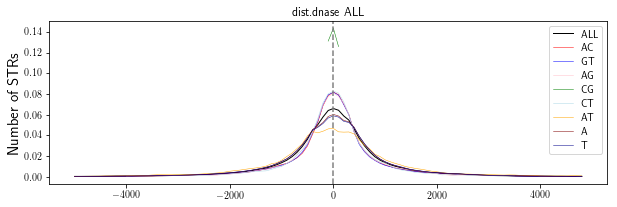

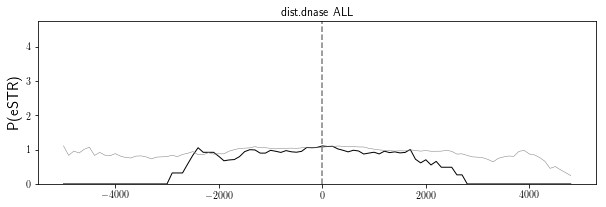

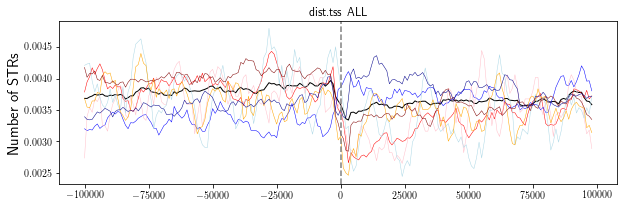

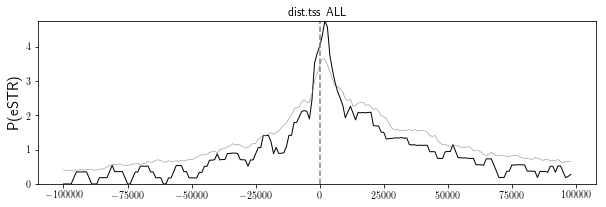

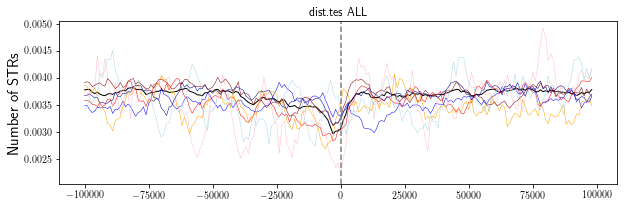

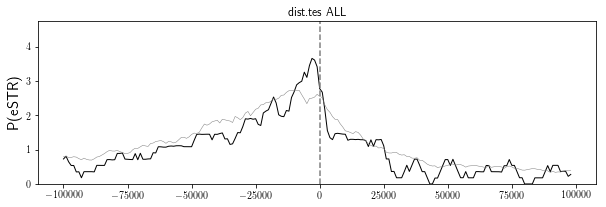

In [8]:
PlotPosition(plotdata["WholeBlood"][0], p_all, pcausal_all, "None", "ALL", np.mean(pavg_all), np.mean(pcausal_avg_all))